# TP Aprendizaje Automático 2
- Alsop Agustin
- Hachen Rocio

## Introducción

### Librerias

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, classification_report
from matplotlib.lines import Line2D
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

### Funciones

In [ ]:
def simpleImputerPerMonth(x_train: pd.DataFrame, x_test: pd.DataFrame, imputer_method : str, columns : list) -> tuple:
    """
    
    """
    for month in range(1, 13):
        
        imputer = SimpleImputer(strategy=imputer_method)
        
        # Filtrar el DataFrame por el mes y realizar la imputación
        train_filter = x_train['Date'].dt.month == month
        test_filter = x_test['Date'].dt.month == month
        
        x_train.loc[train_filter, columns] = imputer.fit_transform(x_train.loc[train_filter, columns])
        x_test.loc[test_filter, columns] = imputer.transform(x_test.loc[test_filter, columns])

    return(x_train, x_test)

def boxplots(X,y, columns):
  data = pd.concat([pd.DataFrame(y, columns=['RainTomorrow']), pd.DataFrame(X, columns=columns)], axis=1)

  num_features = X.shape[1]
  num_rows = num_features // 3 +1

  fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
  fig.subplots_adjust(hspace=0.5)

  # Se recorre cada feature para generar su diagrama de caja respecto de la salida
  for i, feature in enumerate(data.columns[1:]):
      row = i // 3
      col = i % 3
      sns.boxplot(x='RainTomorrow', y=feature, hue='RainTomorrow', data=data, ax=axes[row, col], palette=['blue', 'coral'], legend=False)
      axes[row, col].set_title(f'Diagrama de caja de {feature}')
      axes[row, col].set_xlabel('RainTomorrow')
      axes[row, col].set_ylabel(feature)
      axes[row, col].set_xticks([0, 1])
      axes[row, col].set_xticklabels(['No Lloverá', 'Lloverá'])

  # Eliminar subplots vacíos si es necesario
  if num_features % 3 != 0:
      for i in range(num_features % 3, 3):
          fig.delaxes(axes[num_rows - 1, i])

  plt.show()

### Carga de datos

In [67]:
data = pd.read_csv('weatherAUS.csv')

In [68]:
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [69]:
ciudades = list(data['Location'].unique())
len(ciudades)

49

Eleccion de 10 ciudades de manera aleatoria

In [ ]:
# import random
# ciudades = list(data['Location'].unique())
# ciudades_elegidas = []
# for i in range(0,10):
#     aleatorio = random.randint(0,48-i)
#     ciudades_elegidas.append(ciudades[aleatorio])
#     ciudades.pop(aleatorio)

In [70]:
# 10 Ciudades seleccionadas de manera aleatoria
ciudades_elegidas = ['Cobar',
 'Perth',
 'Penrith',
 'WaggaWagga',
 'Hobart',
 'Cairns',
 'Bendigo',
 'Uluru',
 'MountGinini',
 'MountGambier']

In [71]:
df = data[data['Location'].isin(ciudades_elegidas)]
print(df['Location'].unique())

#Tomaremos tal como da la posibilidad el trabajo práctico de analizar como si fuera una sola ubicación
df.drop('Location', axis=1, inplace=True)

['Cobar' 'Penrith' 'WaggaWagga' 'MountGinini' 'Bendigo' 'Cairns'
 'MountGambier' 'Perth' 'Hobart' 'Uluru']


C:\Users\alsop\AppData\Local\Temp\ipykernel_22172\3428418781.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Location', axis=1, inplace=True)


In [72]:
print(df.columns)
print(df.dtypes)

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
Date              object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


## Ejercicio 1

### Codificación de Variables

In [105]:
df_use = df.copy() # Para evitar warnings
df['RainToday'] = df_use['RainToday'].astype('category')
df['RainTomorrow'] = df_use['RainTomorrow'].astype('category')
df['WindGustDir'] = df_use['WindGustDir'].astype('category')
df['WindDir9am'] = df_use['WindDir9am'].astype('category')
df['WindDir3pm'] = df_use['WindDir3pm'].astype('category')
df['Date'] = df_use['Date'].astype('datetime64[ns]')
df

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,0
6050,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,0
6051,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,NaN,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,0
6052,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,0
6053,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,...,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,0
145455,2017-06-21,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,0
145456,2017-06-22,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,0
145457,2017-06-23,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,0


### Análisis y decisión sobre datos faltantes




In [74]:
# Nulls por Variable
nulls = df.isna().sum()
print(nulls)

print(f' Valores null totales: {nulls.sum()}')

Date                 0
MinTemp            165
MaxTemp            100
Rainfall           390
Evaporation      10781
Sunshine         14528
WindGustDir        649
WindGustSpeed      646
WindDir9am        1567
WindDir3pm         461
WindSpeed9am       331
WindSpeed3pm       299
Humidity9am        714
Humidity3pm        542
Pressure9am       6139
Pressure3pm       6126
Cloud9am         10362
Cloud3pm         10005
Temp9am            488
Temp3pm            336
RainToday          390
RainTomorrow       392
dtype: int64
 Valores null totales: 65411


### Tratamiento de los valores nulos
1) Las filas que tengan Nulls en la columna de la variable a predecir se descartán

2) Las filas que tengan al menos un 50% de Nulls se borrarán, ya que consideramos que rellenarlo por imputación resultaría en un dato creado artificialmente. Verificamos que al hacer esto no se borrara una gran cantidad de información.

3) Para el resto de los datos Null, y luego de haber hecho la validación cruzada, se realizarán imputaciones dependiendo de su distribución y tipo de variable.
    - Asimetría -> Mediana
    - Normal -> Media
    - Bimodal y Categorica -> KNN

#### Paso 1

In [75]:
# Eliminación de las row donde la variable de salida sea null
df = df.dropna(subset=['RainTomorrow'])
print(df['RainTomorrow'].isna().sum())

0


In [76]:
# Guardamos la cantidad total de filas para luego compararlas
con_null = df.shape[0]

#### Paso 2

In [77]:
# Nos quedamos solo con aquellas rows con al menos 11 variables no Null
df = df.dropna(thresh=11)
df.isna().sum()

Date                 0
MinTemp             20
MaxTemp              5
Rainfall           135
Evaporation      10229
Sunshine         13927
WindGustDir        295
WindGustSpeed      292
WindDir9am        1291
WindDir3pm         271
WindSpeed9am        68
WindSpeed3pm       114
Humidity9am        439
Humidity3pm        352
Pressure9am       5701
Pressure3pm       5697
Cloud9am          9835
Cloud3pm          9481
Temp9am            228
Temp3pm            159
RainToday          135
RainTomorrow         0
dtype: int64

In [78]:
sin_null = df.shape[0] # Cantidad de filas restantes luego de la eliminación de Nulls
print(f'Cantidad de filas en el dataset previo al paso 2: {con_null}\nCantidad de filas en el dataset luego de quitar nulls: {sin_null}\nFilas perdidas: {con_null - sin_null}\nPorcentaje de filas perdidas: {round((con_null-sin_null)*100/con_null,2)}%')

Cantidad de filas en el dataset previo al paso 2: 28789
Cantidad de filas en el dataset luego de quitar nulls: 28572
Filas perdidas: 217
Porcentaje de filas perdidas: 0.75%


Debido a que el porcentajes de filas quitadas del data set representa un porcentaje minimo del total consideramos válida la operación

In [79]:
decision_map = {
    "No" : 0, "Yes" : 1
}

# Aplicamos el mapeo para crear una nueva columna
df['RainTomorrow'] = df['RainTomorrow'].map(decision_map)


### Validación Cruzada

In [80]:
# Division train - test
x = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

ratio_train = 0.8
ratio_test = 0.2

# Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y.values.reshape(-1,1), test_size=ratio_test, random_state=42) # se utiliza 42 para garantizar que cada vez que se corra el código se obtengan los mismos resultados

print(f'Cantidad de datos luego de la separación')
print(f'Train: {x_train.shape[0]} - 80%\n Test: {x_test.shape[0]} - 20%')

Cantidad de datos luego de la separación
Train: 22857 - 80%
 Test: 5715 - 20%


### Análisis descriptivo

In [81]:
print(x_train.describe(include='all'))

                                 Date       MinTemp       MaxTemp  \
count                           22857  22839.000000  22854.000000   
unique                            NaN           NaN           NaN   
top                               NaN           NaN           NaN   
freq                              NaN           NaN           NaN   
mean    2013-04-23 09:58:52.904580608     11.269587     22.613984   
min               2008-07-01 00:00:00     -8.500000     -4.800000   
25%               2011-02-14 00:00:00      6.100000     16.500000   
50%               2013-07-02 00:00:00     10.700000     22.200000   
75%               2015-06-25 00:00:00     16.500000     28.900000   
max               2017-06-25 00:00:00     31.000000     46.900000   
std                               NaN      6.925657      8.218413   

            Rainfall   Evaporation      Sunshine WindGustDir  WindGustSpeed  \
count   22751.000000  14681.000000  11705.000000       22613   22616.000000   
unique       

#### Matriz de Correlación

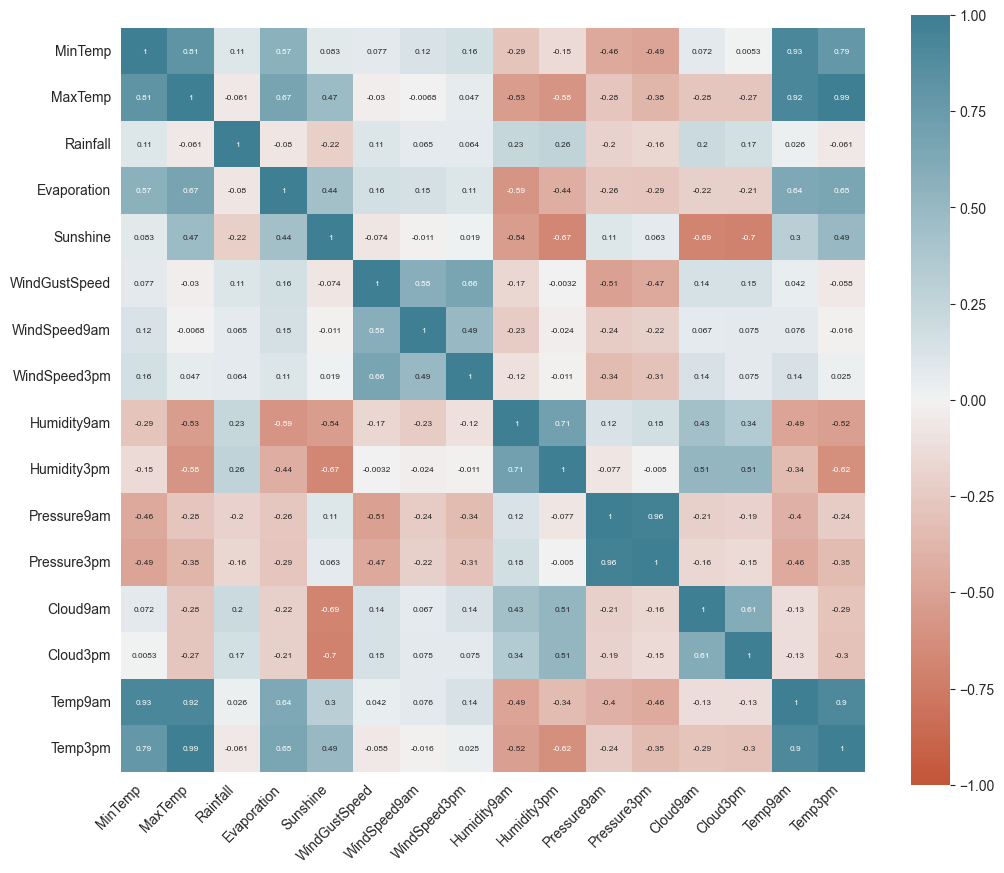

In [82]:
x_train_corr=pd.DataFrame(x_train,columns=x_train.drop(columns=['RainToday', 'Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm']).columns)

plt.figure(figsize=(12,10))
corr = x_train_corr.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

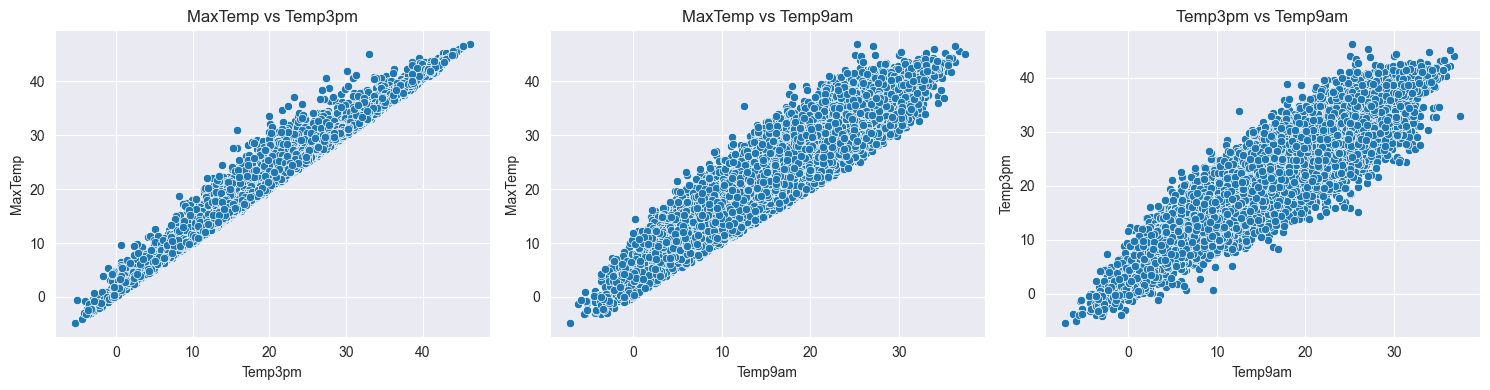

In [83]:
# Visualización de la relación entre algunas variables

pares = [('MaxTemp', 'Temp3pm'), ('MaxTemp', 'Temp9am'), ('Temp3pm', 'Temp9am')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

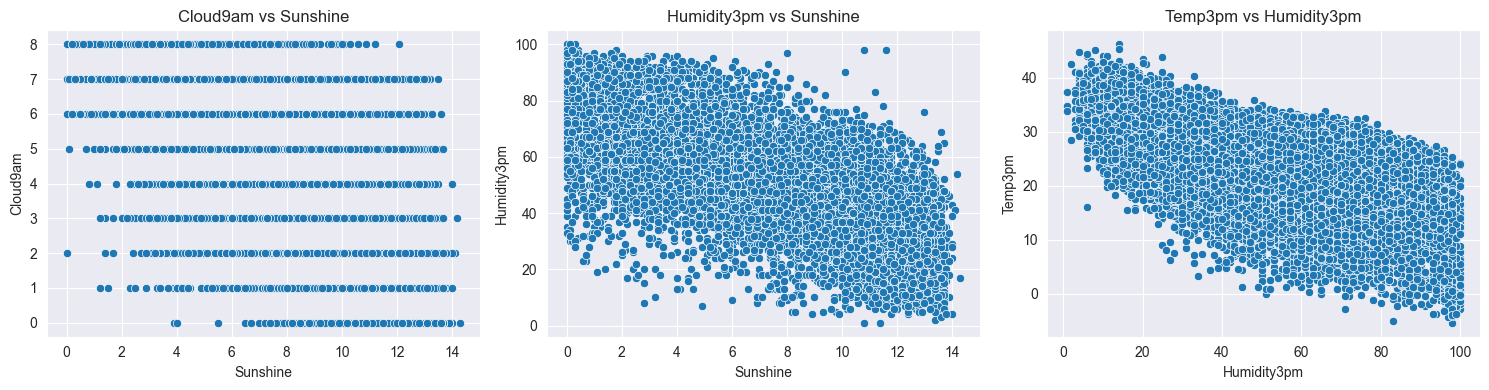

In [84]:
# Visualización de la relación negativa entre algunas variables

pares = [('Cloud9am', 'Sunshine'), ('Humidity3pm', 'Sunshine'), ('Temp3pm', 'Humidity3pm')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

#### Analisis por variable individual

Para poder hacer un mejor análisis sobre los datos (presencia de outliers, distribución de los datos, etc.) decidimos graficar la distribución de cada variable. Además, incluímos la variable categórica "RainToday" en cada uno de los gráficos para poder apreciar mejor si los outliers realmente eran valores atípicos, o si se justificaban por su categoría.

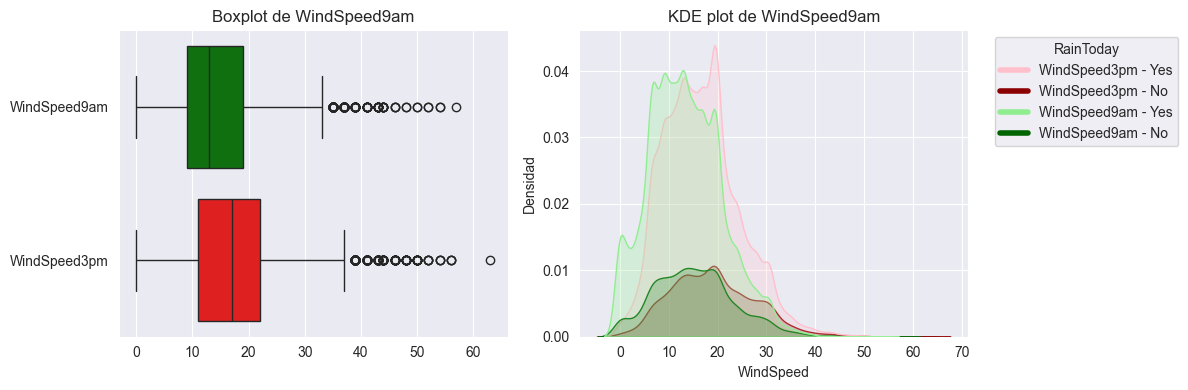

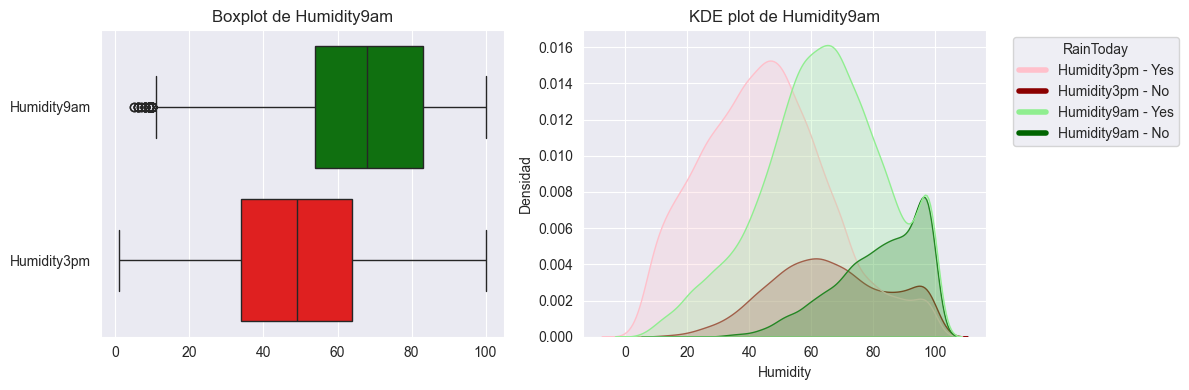

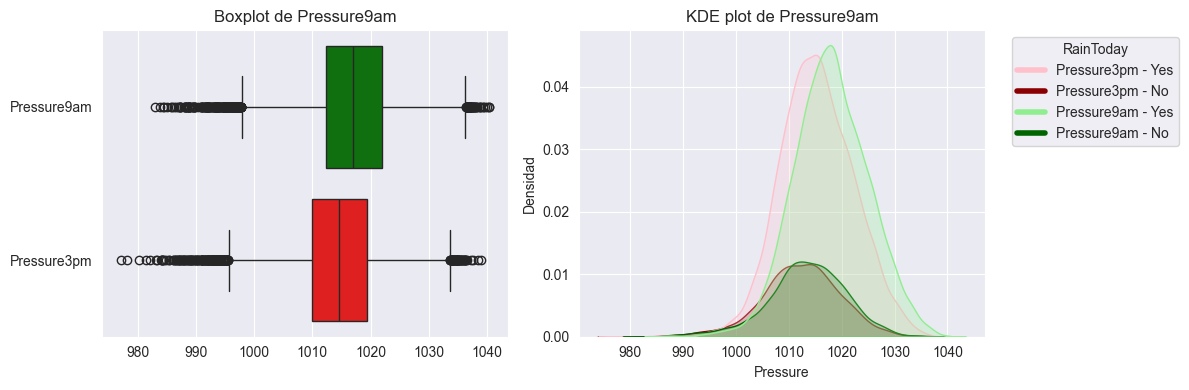

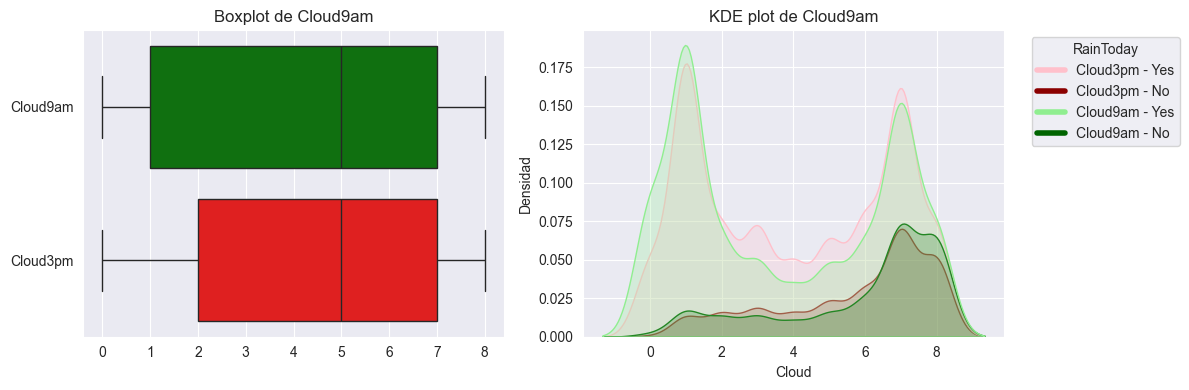

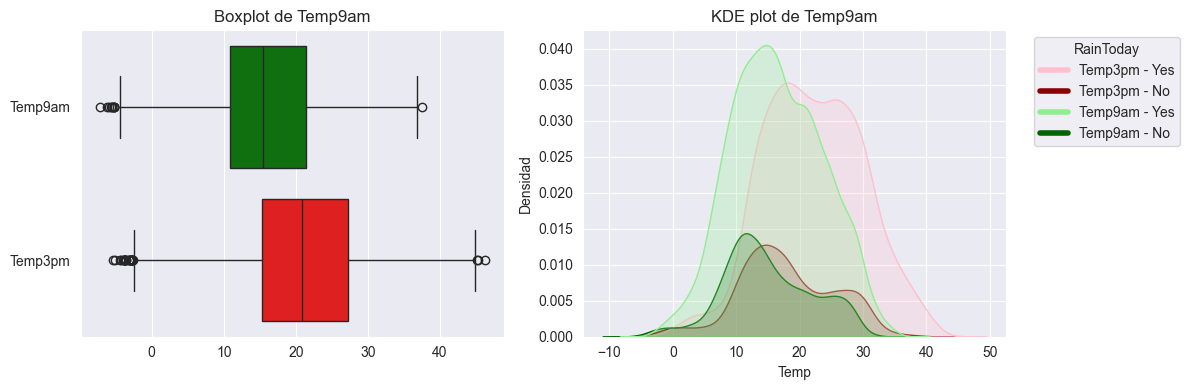

In [85]:


x_train_grafico=pd.DataFrame(x_train,columns=x_train.drop(columns=['Date']).columns)

am_pm_list = ["WindSpeed","Humidity","Pressure","Cloud","Temp"]

sns.set_style("darkgrid")
# Definir las paletas personalizadas
palette_a = ['lightgreen', 'darkgreen']  # Verde oscuro y verde claro
palette_b = ['pink', 'darkred'] 
palette_c = ['green', 'red']           # Rojo claro y rojo oscuro
for variable in am_pm_list:

    am = variable + '9am'
    pm = variable + '3pm'
    # Crear la figura
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.boxplot(data=x_train[[am,pm]], ax=axs[0], 
                palette=palette_c,orient="h")
    axs[0].set_title(f'Boxplot de {am}')

    # Graficar el KDE para Temp3pm con rojo oscuro y rojo claro (correspondiente a 'Yes' y 'No')
    sns.kdeplot(data=x_train, x=pm, fill=True, hue='RainToday', 
                palette=palette_b, label=pm)
    axs[1].set_title(f'KDE plot de {pm}')
    axs[1].set_ylabel('Densidad')


    # Graficar el KDE para Temp9am con verde oscuro y verde claro (correspondiente a 'Yes' y 'No')
    sns.kdeplot(data=x_train, x=am, fill=True, hue='RainToday', 
                palette=palette_a, label=am)
    axs[1].set_title(f'KDE plot de {am}')
    axs[1].set_ylabel('Densidad')

    # Añadir la leyenda personalizada que relacione los colores con 'Yes' y 'No'
    # Cada hue tiene 'Yes' y 'No', por lo que mostramos dos entradas para cada variable
    legend_labels = [f'{pm} - Yes', f'{pm} - No', f'{am} - Yes', f'{am} - No']
    colors = palette_b + palette_a  # Los colores que usaste

    # Crear los elementos de la leyenda

    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, legend_labels)]

    # Colocar la leyenda en la figura
    plt.legend(handles=legend_elements, title='RainToday', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(variable)
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

    x_train_grafico = x_train_grafico.drop(columns=[am,pm])





MinTemp
count    22839.000000
mean        11.269587
std          6.925657
min         -8.500000
25%          6.100000
50%         10.700000
75%         16.500000
max         31.000000
Name: MinTemp, dtype: float64 



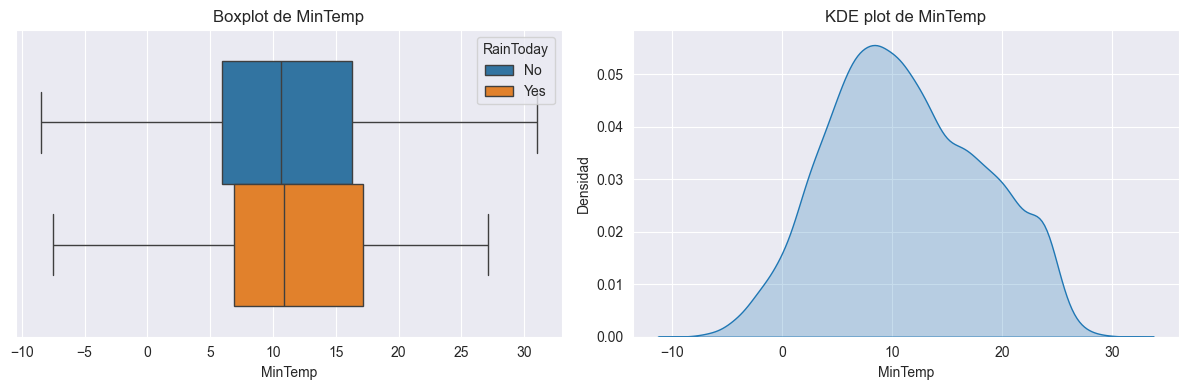

#############################################################################################
MaxTemp
count    22854.000000
mean        22.613984
std          8.218413
min         -4.800000
25%         16.500000
50%         22.200000
75%         28.900000
max         46.900000
Name: MaxTemp, dtype: float64 



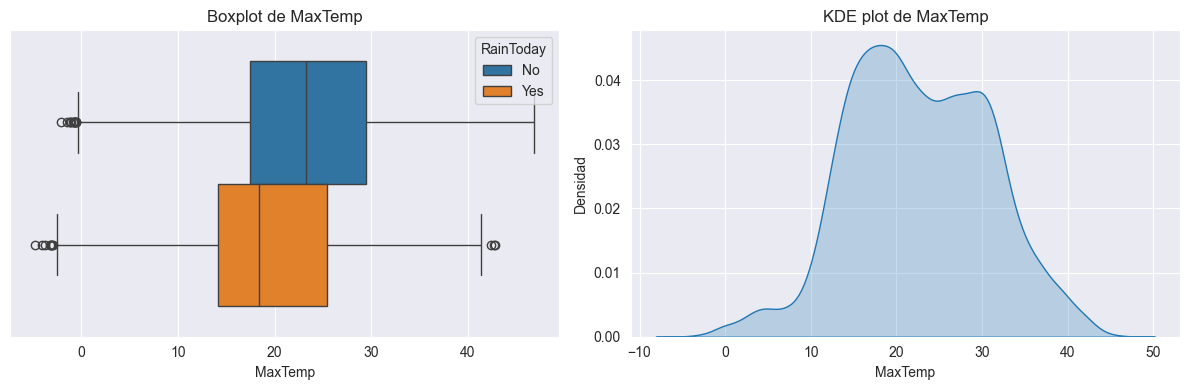

#############################################################################################
Rainfall
count    22751.000000
mean         2.275575
std          8.438577
min          0.000000
25%          0.000000
50%          0.000000
75%          0.600000
max        278.400000
Name: Rainfall, dtype: float64 



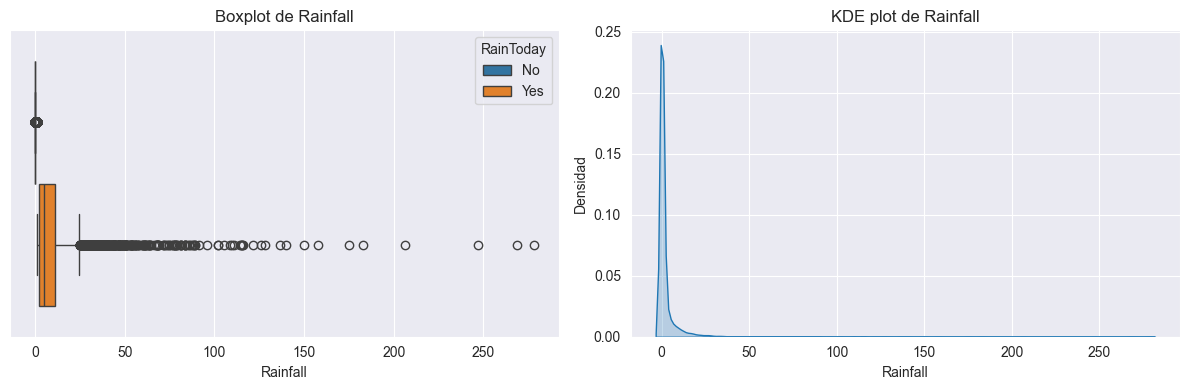

#############################################################################################
Evaporation
count    14681.000000
mean         5.017111
std          3.817592
min          0.000000
25%          2.200000
50%          4.200000
75%          7.000000
max         86.200000
Name: Evaporation, dtype: float64 



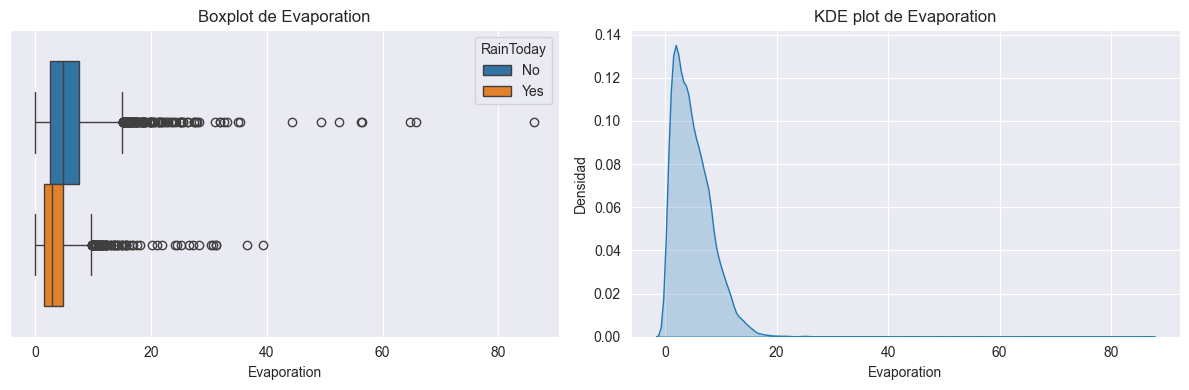

#############################################################################################
Sunshine
count    11705.000000
mean         7.575976
std          3.776202
min          0.000000
25%          4.800000
50%          8.200000
75%         10.700000
max         14.300000
Name: Sunshine, dtype: float64 



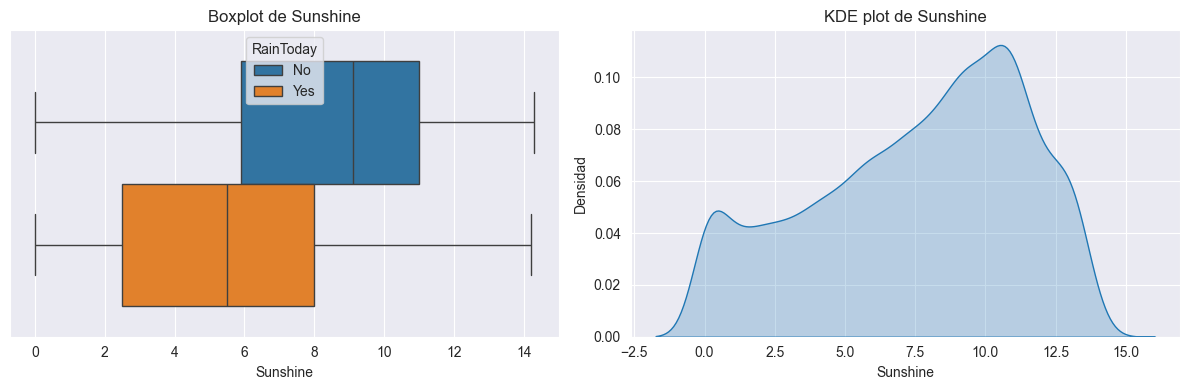

#############################################################################################
WindGustSpeed
count    22616.000000
mean        39.334542
std         13.863066
min          7.000000
25%         30.000000
50%         37.000000
75%         46.000000
max        130.000000
Name: WindGustSpeed, dtype: float64 



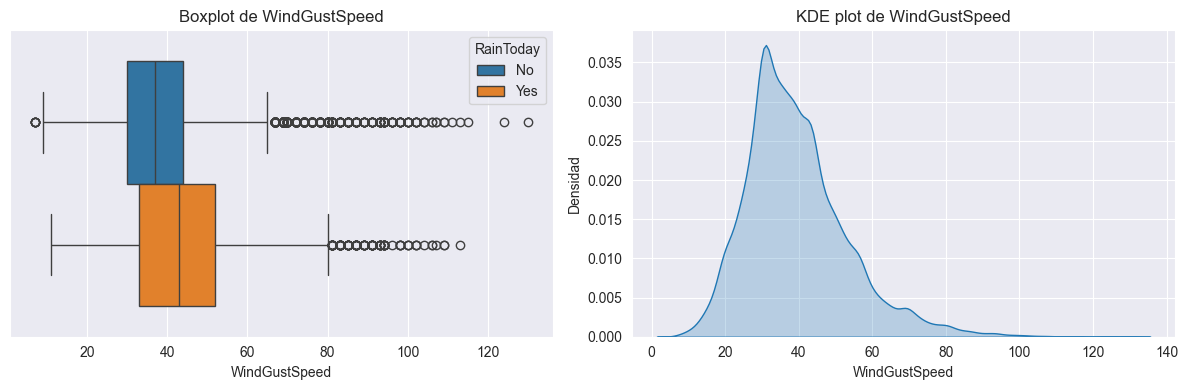

#############################################################################################
RainToday
count     22751
unique        2
top          No
freq      17784
Name: RainToday, dtype: object 



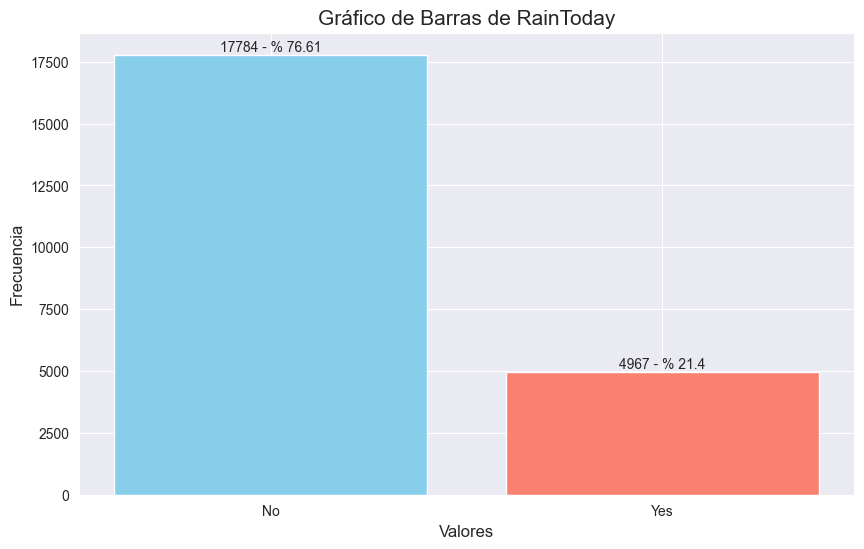

#############################################################################################
WindGustDir
count     22613
unique       16
top          SW
freq       2061
Name: WindGustDir, dtype: object 



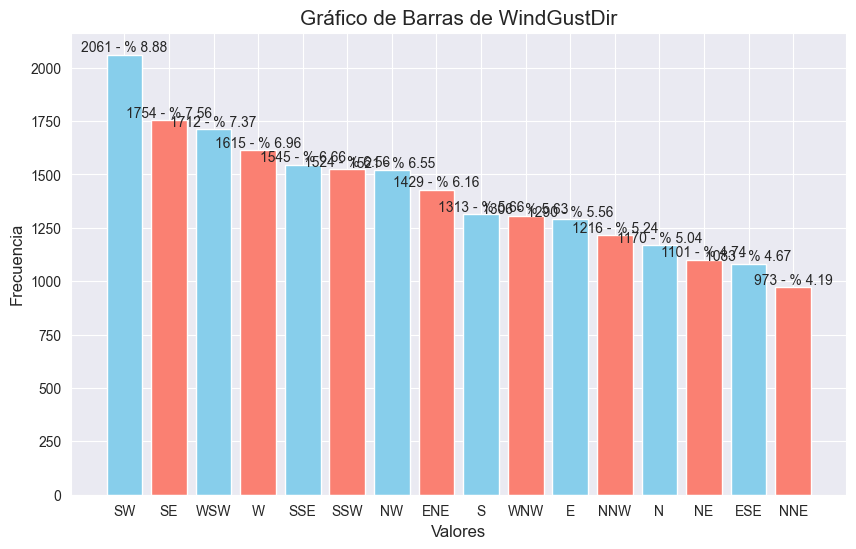

#############################################################################################
WindDir9am
count     21810
unique       16
top         SSE
freq       2298
Name: WindDir9am, dtype: object 



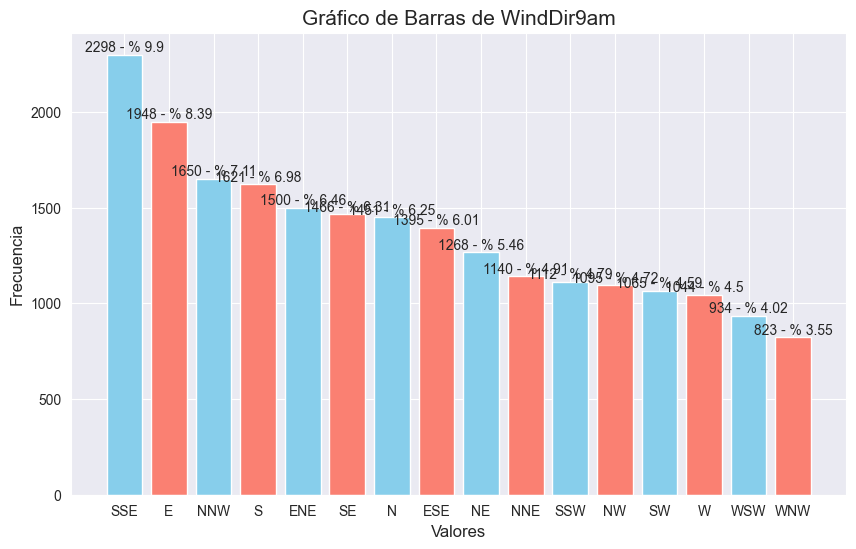

#############################################################################################
WindDir3pm
count     22636
unique       16
top          SW
freq       1888
Name: WindDir3pm, dtype: object 



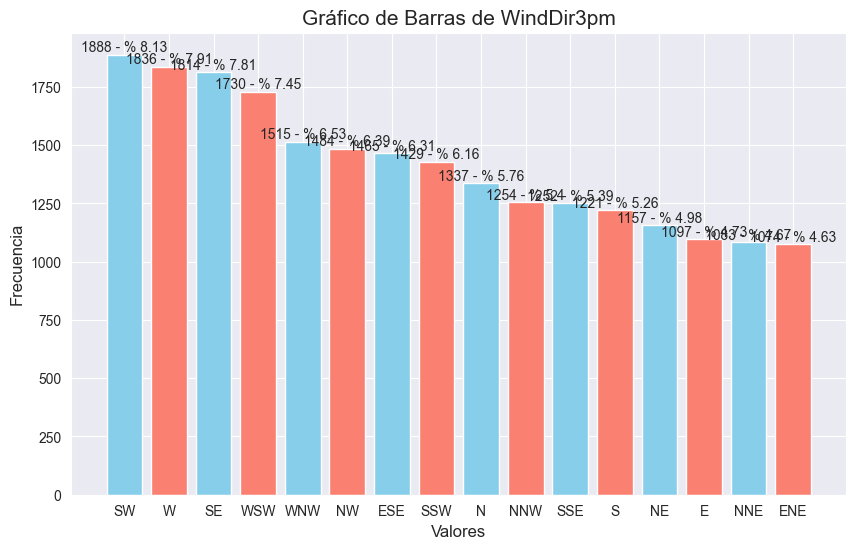

#############################################################################################


In [86]:
for columna in x_train_grafico:
    if not columna in ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
        print(columna)
        print(x_train[columna].describe(), '\n')

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(data=x_train, x=columna, hue=f'RainToday', ax=axs[0])
        axs[0].set_title(f'Boxplot de {columna}')

        sns.kdeplot(data=x_train, x=columna, fill=True, ax=axs[1])
        axs[1].set_title(f'KDE plot de {columna}')
        axs[1].set_ylabel('Densidad')

        plt.tight_layout()
        plt.show()

        # for i in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        #     print(i)
        #     fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        #     sns.boxplot(data=x_train, x=columna, hue=f'{i}', ax=axs[0])
        #     axs[0].set_title(f'Boxplot de {columna}')

        #     '''sns.kdeplot(data=x_train, x=columna, fill=True, hue=f'{i}', ax=axs[1])
        #     axs[1].set_title(f'KDE plot de {columna}')
        #     axs[1].set_ylabel('Densidad')'''

        #     plt.tight_layout()
        #     plt.show()
        print('#############################################################################################')

for i in ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    print(i)
    print(x_train[f'{i}'].describe(), '\n')

    count = x_train[f'{i}'].value_counts().reset_index()
    count.columns = ['Valores', 'Frecuencia']

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(count['Valores'].astype(str), count['Frecuencia'], color=['skyblue', 'salmon'])

    # Agregar título y etiquetas
    plt.title(f'Gráfico de Barras de {i}', fontsize=15)
    plt.xlabel('Valores', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Agregar el número encima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text((bar.get_x() + bar.get_width() / 2.0), height, f'{int(height)} - % {round((int(height)/23215)*100,2)}', ha='center', va='bottom')

    # Mostrar el gráfico
    plt.show()
    print('#############################################################################################')



En base a los gráficos, se observan las siguientes distribuciones:
- WindSpeed: Distribución asimétrica a la derecha esto se justifica viendo una gran cantidad de outliers en la parte derecha del boxplot. Estos outliers se presentan para ambos horarios, ademas podemos observar que la mediana de las velocidades de vientos a la 9am es ligeramente inferior que a las 3pm. Por otro lado la influencia si llueve en el dia o no podriamos decir que no afecta a las velocidades.
- Humidity: Distribución aproximadamente normal en el horario de las 3 de la tarde mientras que a la 9 de la mañana se observa una asimetria hacia la izquierda ibteniendo en promedio mayor humedad a la mañana que a la tarde. Se puede observar como la humedad se ve afectada positivamente los dias de lluvia obteniendo puntajes mayores.
- Preassure: Distribucion aproximadamente normal con una leve asimetria hacia la izquierda debido a que se pueden observar para ambos horarios mayor cantidad de outliers a la izquierda del boxplot. Tambien podemos observar que los dias que llueve la media de la presion atmosférica es levemente menor
- Cloud: Distribución Bimodal similares para ambos horarios. Podemos observar una moda alrededor de 1 y otra alrededor de los 7 puntos. Los dias de lluvia vemos como deja de ser una distribucion bimodal, a una con una aproximadamente normal asimetrica hacia la izquierda.
- Temp: Distribución aproximadamente normal con outliers en sus dos colas con mayor frecuencioa en el lado izquierdo. Los mismos se presentan para ambos horarios. Se oberva que los dias de lluvia la termperatura en inferior.
- MinTemp: Distribución apróximadamente normal.
- MaxTemp: Distribución bimodal. El boxplot presenta algunos outlier, los dias de lluvia la mediana de las maximas temperaturas es inferior.
- Rainfall: Distribución muy asimetrica hacia la derecha, podemos observar gran cantidad de outliers en la parte derecha del boxplot, lo que explica esta gran asimetría
- Evaporation: Al igual que Rainfall podemos observar una distribución asimétrica hacia la derecha. Tambien se observan gran cantidad de outliers tanto para los dias de lluvia como para los que no.
- Sunshine: Distribución bimodal, una muy marcada al rededor de los 10 puntos y otra mas leve al rededor de los 0 puntos. Si bien es intuitivo se observa que los dias de lluvia la mediana de los puntos de sunshine son inferiores.
- WindGustSpeed: Distribución aproximadamente normal asimétrica a la derecha. Se pueden observar outliers en la parte derecha de los boxplot. Ademas los dias de lluvia presentan una mediana mayor de WindGustSpeed
- RainToday: Podemos observar un desbalanceo en los datos dando un 76% de los datos provienen de dias que no llueven mientras que un 21% que no.
- WindGustDir: Podemos observer que los datos se distribuyen entre un 4% a 8% entre cada categoria, siendo mas frecuentes WINDGUSTDIR del sur oeste y los menos fruentes del NorNorEste
- WindDir9am: Podemos observer que los datos se distribuyen entre un 3% a 10% entre cada categoria, siendo mas frecuentes los vientos en dirección al sursuereste y los menos fruentes del oestenoroeste
- WindDir3pm: Podemos observer que los datos se distribuyen entre un 4% a 8% entre cada categoria, siendo mas frecuentes los vientos en dirección al sur oeste y los menos fruentes del estenoreste

#### Paso 3 (Imputación de datos)

En base al análisis descriptivo, decidimos utilizar distintos métodos de imputación según la distribución y el tipo de variable.

### Continuas
- MinTemp: Media
- Temp9am: Media
- Rainfall: Mediana
- Evaporation: Mediana
- WindGustSpeed: Mediana
- Pressure3pm: Mediana
- Pressure9am: Mediana
- WindSpeed3pm: KNN
- WindSpeed9am: KNN
- Humidity3pm: KNN
- Humidity9am: KNN
- Cloud9am: KNN
- Cloud3pm: KNN
- Temp3pm: KNN
- MaxTemp: KNN
- Sunshine: KNN

### Cualitativas
- WindGustDir: KNN
- WindDir9am: KNN
- WindDir3pm: KNN
- RainToday: KNN

In [88]:
# Creamos copias de los dataset
x_train_imputer = x_train.copy()
x_test_imputer = x_test.copy()

# Imputamos por la media
columns_normal = ['MinTemp', 'Temp9am']
x_train_imputer, x_test_imputer = simpleImputerPerMonth(x_train_imputer, x_test_imputer, 'mean', columns_normal)

# Imputamos por la mediana
columns_asimetric = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'Pressure3pm', 'Pressure9am']
x_train_imputer, x_test_imputer = simpleImputerPerMonth(x_train_imputer, x_test_imputer, 'median', columns_asimetric)

# Imputamos por KNN
columns_bimodal = ['WindSpeed3pm', 'WindSpeed9am', 'Humidity3pm', 'Humidity9am', 'Cloud9am','Cloud3pm', 'Temp3pm', 'MaxTemp','Sunshine']
knn_imputer = KNNImputer()
x_train_imputer[columns_bimodal]= knn_imputer.fit_transform(x_train_imputer[columns_bimodal])
x_test_imputer[columns_bimodal]= knn_imputer.transform(x_test_imputer[columns_bimodal])

# Verificamos
x_train_imputer.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir       244
WindGustSpeed       0
WindDir9am       1047
WindDir3pm        221
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday         106
dtype: int64

Para agilizar el analisis y la codificación de las variables de direcciones de viento decidimos pasar de 16 direcciones a las 8 mas comunes:

- Norte
- NorEste
- Este
- SurEste
- Sur
- SurOeste
- Oeste
- NorOeste

In [89]:
# Creamos un diccionario de mapeo
direction_map = {
    'N': 'N', 'NNE': 'N', 'NE': 'NE', 'ENE': 'E',
    'E': 'E', 'ESE': 'SE', 'SE': 'SE', 'SSE': 'S',
    'S': 'S', 'SSW': 'S', 'SW': 'SW', 'WSW': 'W',
    'W': 'W', 'WNW': 'NW', 'NW': 'NW', 'NNW': 'N'
}

# Aplicamos el mapeo para crear una nueva columna
x_train_imputer['WindGustDir'] = x_train_imputer['WindGustDir'].map(direction_map)
x_test_imputer['WindGustDir'] = x_test_imputer['WindGustDir'].map(direction_map)
x_train_imputer['WindDir9am'] = x_train_imputer['WindDir9am'].map(direction_map)
x_test_imputer['WindDir9am'] = x_test_imputer['WindDir9am'].map(direction_map)
x_train_imputer['WindDir3pm'] = x_train_imputer['WindDir3pm'].map(direction_map)
x_test_imputer['WindDir3pm'] = x_test_imputer['WindDir3pm'].map(direction_map)


Utilizamos la codificación de LabelEncoder para las variables de direccion de vientos

In [90]:
x_train_imputer_v2 = x_train_imputer.copy()
x_test_imputer_v2 = x_test_imputer.copy()

for var in ['WindGustDir', 'WindDir9am', 'WindDir3pm','RainToday']:
    label_encoder = LabelEncoder()
    x_train_imputer_v2[var] = label_encoder.fit_transform(x_train_imputer_v2[var])
    x_test_imputer_v2[var] = label_encoder.transform(x_test_imputer_v2[var])
    

In [91]:
# Eliminamos la columna original y unir las columnas codificadas
x_train_imputer_v2 = x_train_imputer_v2.drop(columns=['Date']).reset_index(drop=True)
x_test_imputer_v2 = x_test_imputer_v2.drop(columns=['Date']).reset_index(drop=True)

columns_bimodal_cat = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
knn_imputer = KNNImputer()
x_train_imputer_v2[columns_bimodal_cat]= knn_imputer.fit_transform(x_train_imputer_v2[columns_bimodal_cat])
x_test_imputer_v2[columns_bimodal_cat]= knn_imputer.transform(x_test_imputer_v2[columns_bimodal_cat])
x_train_imputer_v2.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

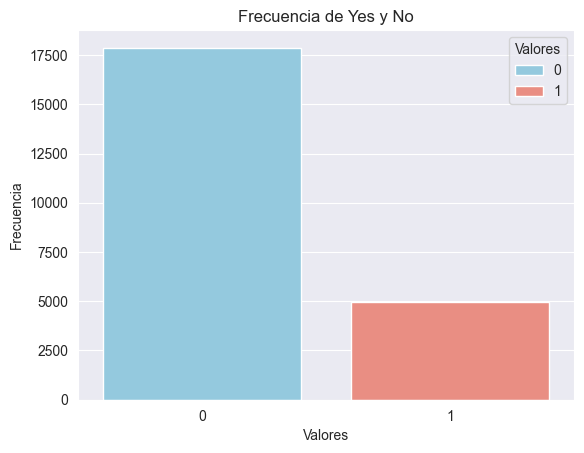

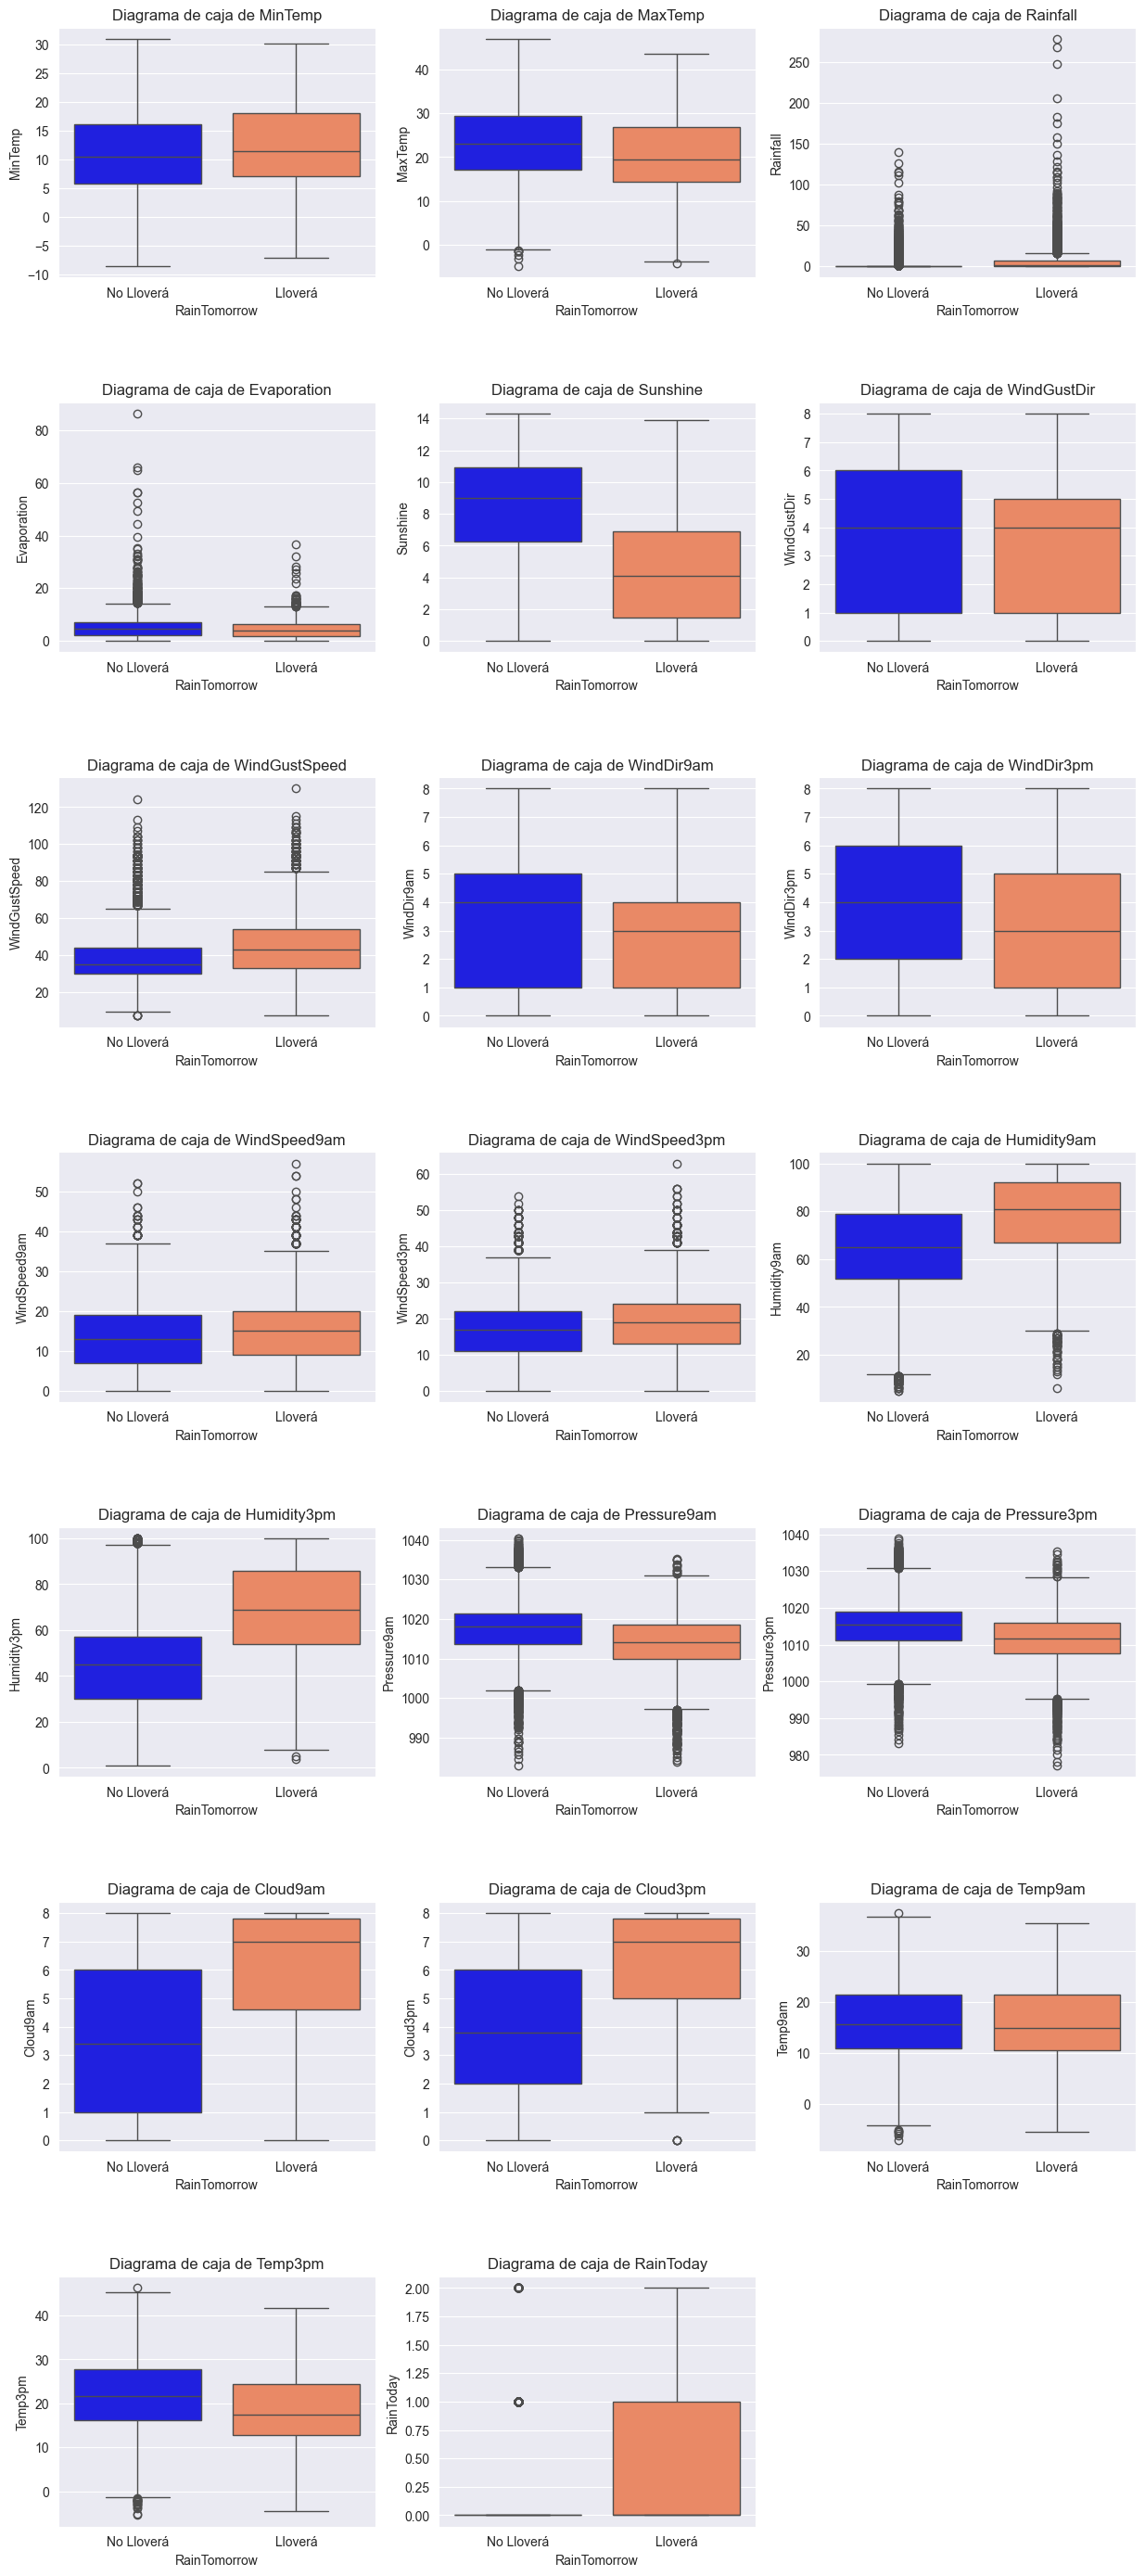

In [93]:
# Calcular la frecuencia de cada valor
dataframe = pd.DataFrame(y_train)
value_counts = dataframe[0].value_counts().reset_index()
value_counts.columns = ['Valores', 'Frecuencia']

# Crear el gráfico de barras
sns.barplot(x='Valores', y='Frecuencia', hue='Valores', data=value_counts, palette=['skyblue', 'salmon'])
plt.title('Frecuencia de Yes y No')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()


boxplots(x_train_imputer_v2, y_train, x_train_imputer_v2.columns)

Podemos observar a niveles general un gran desbalanceo de datos, alrededor de 5 veces mas valores negativos que positivos de nuestra variable a predecir.

### Escalado de Datos

In [94]:
# scaler=StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train_imputer_v2)
# x_test_scaled = scaler.transform(x_test_imputer_v2)

Debido a que vimos variables con una gran cantidad de outliers decidimos usar un escalador mas robusto que no este influenciado por los mismos

In [95]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train_imputer_v2)
x_test_scaled = scaler.transform(x_test_imputer_v2)


## Regresión Logistica

Primero experimentamos sin ningun tipo de balanceo en los datos.

In [96]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(x_train_scaled, y_train)
y_pred = logistic_model.predict(x_test_scaled)

accuracy_logreg = accuracy_score(y_test, y_pred)
confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
classification_report_logreg = classification_report(y_test, y_pred)

print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg}')
print("\nMatriz de confusión:")
print(confusion_matrix_logreg)
print("\nReporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg:
Precisión: 0.8556430446194225

Matriz de confusión:
[[4228  243]
 [ 582  662]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4471
           1       0.73      0.53      0.62      1244

    accuracy                           0.86      5715
   macro avg       0.81      0.74      0.76      5715
weighted avg       0.85      0.86      0.85      5715



c:\Git\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Git\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logistic_model.predict_proba(x_test_scaled)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

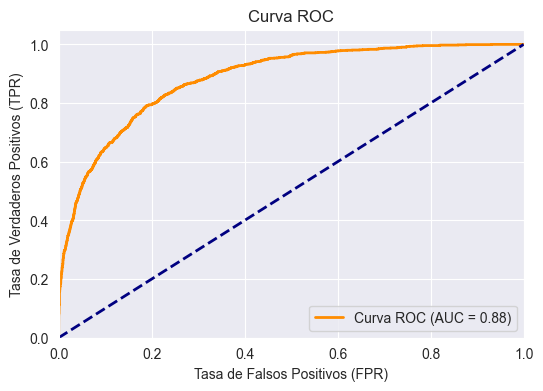

In [98]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Podemos observar que 

In [99]:
logistic_model2 = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model2.fit(x_train_scaled, y_train)
y_pred = logistic_model2.predict(x_test_scaled)

accuracy_logreg = accuracy_score(y_test, y_pred)
confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
classification_report_logreg = classification_report(y_test, y_pred)

print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg}')
print("\nMatriz de confusión:")
print(confusion_matrix_logreg)
print("\nReporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg:
Precisión: 0.8029746281714786

Matriz de confusión:
[[3607  864]
 [ 262  982]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4471
           1       0.53      0.79      0.64      1244

    accuracy                           0.80      5715
   macro avg       0.73      0.80      0.75      5715
weighted avg       0.85      0.80      0.82      5715



c:\Git\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Git\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
# Obtengo las probabilidades de predicción del modelo
y_probs2 = logistic_model2.predict_proba(x_test_scaled)[:, 1]

# Calculo la ROC y el AUC
fpr2, tpr2, thresholds = roc_curve(y_test, y_probs2)
roc_auc2 = auc(fpr2, tpr2)

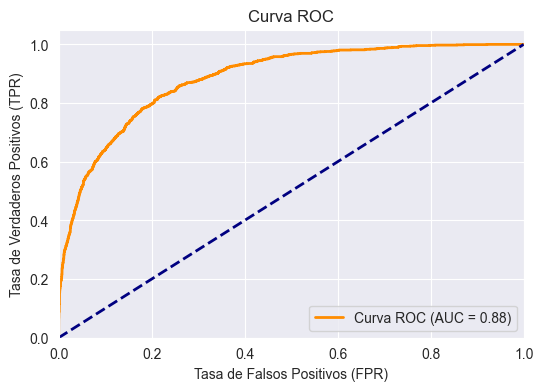

In [101]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Modelo base

In [102]:
dummy_clf = DummyClassifier(strategy="stratified",random_state=42) # aprender qué hace
"""“stratified”: the predict_proba method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities.
 The predict method returns 
the class label which got probability one in the one-hot vector of predict_proba. Each sampled row of both methods is therefore independent and identically distributed."""
dummy_clf.fit(x_train_scaled, y_train)
dummy_pred = dummy_clf.predict(x_test_scaled)

accuracy_logreg = accuracy_score(y_test, dummy_pred)
confusion_matrix_logreg = confusion_matrix(y_test, dummy_pred)
classification_report_logreg = classification_report(y_test, dummy_pred)

print("Métricas para DummyClassifier:")
print(f'Precisión: {accuracy_logreg}')
print("\nMatriz de confusión:")
print(confusion_matrix_logreg)
print("\nReporte de clasificación:")
print(classification_report_logreg)

Métricas para DummyClassifier:
Precisión: 0.6619422572178477

Matriz de confusión:
[[3513  958]
 [ 974  270]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      4471
           1       0.22      0.22      0.22      1244

    accuracy                           0.66      5715
   macro avg       0.50      0.50      0.50      5715
weighted avg       0.66      0.66      0.66      5715



In [103]:
# Obtengo las probabilidades de predicción del modelo
y_probs_dummy = dummy_clf.predict_proba(x_test_scaled)[:, 1]

# Calculo la ROC y el AUC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, y_probs_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

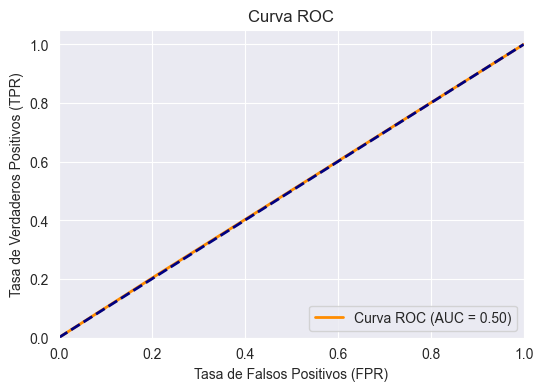

In [104]:
# Graficamos la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_dummy, tpr_dummy, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_dummy)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

El área debajo de la curva (AUC) dio 0.5. Esto ocurre cuando el modelo no tiene capacidad discriminativa, lo cual es correcto, ya que nuestro DummyClassifier está clasificando de manera totalmente aleatoria. 